In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ostateczny algorytm pracy ze wszystkich laboratoriów

### Ponizej poprzednie implementacje i testy które dały taki rezultat

In [138]:

class MultiLayers:
    def __init__(self, input_size, layer_sizes, output_size, 
                 weight_init="normal", activation="sigm", exit="linear", measure="mse",
                 momentum = False, rmsProp=False, normalization="none"):
        ## ________________________________________ Initialization ________________________________________ ##
        # 0) layers and architecture init
        np.random.seed(50)
        layers = [input_size] + layer_sizes + [output_size]
        IN = layers[:-1]
        OUT = layers[1:]
        if momentum==True: self.momentum = True
        else: self.momentum = False
        if rmsProp==True: self.rmsProp = True
        else: self.rmsProp = False
        if normalization=="none": self.normalization = None
        if normalization=="std": self.normalization = "std"
        if normalization=="minmax": self.normalization = "minmax"
        # 1) __ wieghts init
        if weight_init == "normal":
            def initializer(a,b): return np.random.normal(0,1, size=(a,b))
        elif weight_init == "he":
            def initializer(a,b): return np.random.normal(0,np.sqrt(2/(a+b)), size=(a,b))
        elif weight_init=="xavier":
            def initializer(a,b): return np.random.normal(0,np.sqrt(6/2*(a+b)), size=(a,b))
        elif weight_init=="uniform":
            def initializer(a,b): return np.random.uniform(0,1, size=(a,b))
        # 2) __ Loss function
        if measure=="mse": self.measure = self.mse_loss
        if measure=="f1": self.measure = self.cross_entropy_loss
        # 3) __ Activation function
        if activation=="relu": 
            self.activation = self.relu
            self.derivative = self.relu_derivative
        elif activation=="tanh": 
            self.activation = self.tanh
            self.derivative = self.tanh_derivative
        elif activation=="linear": 
            self.activation = self.linear
            self.derivative = self.linear_derivative
        elif activation=="sigm": 
            self.activation = self.sigmoid
            self.derivative = self.sigmoid_derivative
        # 4) __ exit activation
        if exit=="linear" and self.normalization==None: self.exit = self.linear
        if exit=="linear" and self.normalization=="std": self.exit = self.denormalize_std
        if exit=="linear" and self.normalization=="minmax": self.exit = self.denormalize_minmax
        if exit!="linear": self.exit = self.softmax

        # 5) _______ weights and biases initialation ______
        self.weights = [initializer(input,output) for (input,output) in zip(IN,OUT)]
        self.biases = [np.zeros(output) for output in OUT]
        # 6) _______ arrays for neurons calculating _______
        self.summed = [None]*len(self.weights) # _______ calculating linear combinations on a single neuron
        self.activated = [None]*len(self.weights) # _______ calculated activation on linear combinations
        # 7) _______ Momentum - velocity _________
        self.V_biases = [np.zeros(b.shape) for b in self.biases]
        self.V_weights = [np.zeros(w.shape) for w in self.weights]
        # 8) _______ Means for RMS prop  _________
        self.M_biases = [np.zeros(b.shape) for b in self.biases]
        self.M_weigths = [np.zeros(w.shape) for w in self.weights]

        # 9) __ arrays for errors
        self.errors_array = []
        self.error_matrix=[]
        self.epoch_n=[]
        self.scores = []

    #####
    ## ________________________________________ Activation Formulas ________________________________________ ##
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    def relu(self, x):
        return np.maximum(0, x)
    def tanh(self, x):
        return np.tanh(x)
    def linear(self, x):
        return x
    # 1) __ activation - derivative formulas
    def relu_derivative(self,x):
        return np.where(x > 0, 1, 0)
    def tanh_derivative(self,x):
        return 1 - np.tanh(x)**2
    def sigmoid_derivative(self,x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    def linear_derivative(self,x):
        return 1
    def softmax(self, x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)
    # 2) __ loss function - regression
    def mse_loss(self, y_true, y_pred):
        return np.mean((y_true - y_pred)**2)
    def mse_loss_derivative(self, y_true, y_pred):
        return 2 * (y_pred - y_true) / len(y_true)
    # 3) __ loss function - classification
    def cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-15  
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  
        return -np.sum(y_true * np.log(y_pred)) / len(y_true)
    def cross_entropy_loss_derivative(self, y_true, y_pred):
        return (y_pred - y_true)
    # 4) ___ f1 - score
    def f1_fun(self, output, y_train):
        true_positives = np.sum((output == 1) & (y_train == 1))
        false_positives = np.sum((output == 1) & (y_train == 0))
        false_negatives = np.sum((output == 0) & (y_train == 1))
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        return f1
    ######
    
## ________________________________________ Fit ________________________________________ ##
##
##
    def forward(self, x):
# 1) _______ Propagacja w przód _______
        if self.normalization=="std": layer=self.normalize_std(x)
        if self.normalization=="minmax": layer=self.normalize_minmax(x)
        layer = x 
        n=len(self.weights)
        self.summed[0] = layer   # ____ first layer

        for i in range(n-1): # ____ go over all layers except first/last  
            self.activated[i] = layer
            layer = np.dot(layer,self.weights[i]) + self.biases[i]
            self.summed[i+1] = layer
            layer = self.activation(layer) 

        self.activated[-1]=layer   # ____ last layer
        output_layer = np.dot(layer,self.weights[-1]) + self.biases[-1] 
        output = self.exit(output_layer)
        return output
    
    def backward(self,y,y_predicted, optimization_method):
# 2) _______ backward algorithm with gradients _______ #
        gradient_biases, gradient_weights = self.gradients(y, y_predicted)
        gradient_biases, gradient_weights = optimization_method(gradient_biases, gradient_weights)
        self.weights = [w- self.learn*g for (w,g) in zip(self.weights, gradient_weights)]
        self.biases = [b- self.learn*g for (b,g) in zip(self.biases,gradient_biases)]

# 3) _______ Train data _______ #
    def train(self, x_train, y_train, epochs, batch_size=None, batching=False ,learning_rate=0.001):
        n=len(x_train)
        if batch_size==None: batch_size=n
        self.x_train = x_train
        # ____ setting network optimization
        self.learn=learning_rate
        self.epochs_number = epochs
        if self.normalization=="std": self.set_normals(x_train,y_train)
        if self.momentum==True and self.rmsProp==True: optimization=self.Adam
        if self.momentum==True and self.rmsProp==False: optimization=self.Momentum_fun
        if self.momentum==False and self.rmsProp==True: optimization=self.RMSProp_fun
        if self.momentum==False and self.rmsProp==False: optimization=self.no_opt

        for epoch in range(epochs):
            indeces = list(range(n))
            if batching: np.random.shuffle(indeces) # shuffling indeces

            # __________ getting new predictions in new epoch for all branches __________
            for k in range(0,n,batch_size):
                part_in_use = indeces[k:k+batch_size]
                x,y = x_train[part_in_use], y_train[part_in_use]
                #~~~~~
                y_predicted = self.forward(x)
                self.backward(y,y_predicted, optimization_method = optimization)
                #~~~~~

            # __________ saving outputs for showing errors __________
            output = self.forward(x_train)
            self.scores.append(self.measure(output, y_train))
            if epoch in range(1, epochs+1, int(epochs/9)) or epoch==epochs:
                self.epoch_n.append(epoch)
                print_error = self.measure(output, y_train)
                if self.measure == self.mse_loss: self.errors_array.append(self.mse_loss(output, y_train))
                if self.measure == self.cross_entropy_loss: self.errors_array.append(self.cross_entropy_loss(output, y_train))
                self.error_matrix.append(self.output_delta)
            # Print f-score
        if self.measure == self.mse_loss: print(f'Epoch {epoch+1}, Training MSE Score: {print_error}\n')
        if self.measure == self.cross_entropy_loss: 
            print(f'Epoch {epoch+1}, Training Cross-Entropy Score: {print_error}\n')
            f1_error = self.f1_fun(np.eye(y_train.shape[1])[self.predict_classification(x_train)],y_train)
            print(f'Epoch {epoch+1}, Training F1 Score: {f1_error}\n')
        return print_error
    
# 4) _____ Gradient implementation ______ ##
    def gradients(self, y, y_predicted):
        n = len(self.weights)
        gradient_biases = [np.zeros(b.shape) for b in self.biases]
        gradient_weights = [np.zeros(w.shape) for w in self.weights]
        if self.measure == self.mse_loss: self.output_delta = self.mse_loss_derivative(y, y_predicted)
        if self.measure == self.cross_entropy_loss: self.output_delta = self.cross_entropy_loss_derivative(y, y_predicted)
        for i in range(1, n+1):
            gradient_biases[-i] = np.sum(self.output_delta, axis=0)
            gradient_weights[-i] = np.dot(self.activated[-i].T, self.output_delta)
            self.output_delta = np.dot(self.output_delta, self.weights[-i].T) * self.derivative(self.summed[-i])
        return gradient_biases,gradient_weights
    
# 5) _______ Predict test data _______ #
    # ___ classification
    def predict_classification(self, x):
        output = self.forward(x)
        return np.argmax(output, axis=1)
    def print_f1_test(self,x_test,y_test):
        print("F1 score test =", self.f1_fun(np.eye(y_test.shape[1])[self.predict_classification(x_test)],y_test))
    # ___ regression
    def predict_regression(self, x_test, y_test):
        indices=[]
        nearest_indices = np.array([np.argmin(np.abs(self.x_train - value)) for value in x_test])
        for i in range(len(nearest_indices)):
            k = int(np.where(np.abs(self.x_train - x_test[i]) == np.min(np.abs(self.x_train - x_test[i])))[0])
            indices.append(k)
        y_predicted = self.forward(self.x_train[indices])
        difference_test = y_test - y_predicted
        return difference_test
    def print_mse_test(self,x_test, y_test):
        difference_test = self.predict_regression(x_test, y_test)
        print("MSE test =", np.mean(np.square(difference_test)))

##
##    
## ________________________________________ Improvements - direction funs ________________________________________ ##
    # 0) ___ normalization of data
    def set_normals(self,x,y):
        self.meanx = np.mean(x)
        self.stdx = np.std(x)
        self.meany = np.mean(y)
        self.stdy = np.std(y)
    def normalize_std(self,x):
        return (x-self.meanx)/self.stdx
    def denormalize_std(self,y_pred):
        return y_pred*self.stdy + self.meany
    def normalize_minmax(self,x):
        return (x-min(x))/(max(x)-min(x))
    def denormalize_minmax(self,y_pred):
        return y_pred*(max(y_pred)-min(y_pred)) + min(y_pred)
    ## 1) ___ improvements - Momentum
    def Momentum_fun(self,G_biases,G_weights, beta = 0.9):
        self.V_biases = [beta*vb+gb for (vb,gb) in zip(self.V_biases, G_biases)]
        self.V_weights = [beta*vw+gw for (vw,gw) in zip(self.V_weights, G_weights)]
        return self.V_biases, self.V_weights
    ## 2) ___ improvements - RMSprop
    def RMSProp_fun(self,G_biases,G_weights,beta = 0.9):
        self.M_biases = [beta*mb + (1-beta)*np.square(gb) for (mb,gb) in zip(self.M_biases,G_biases)]
        self.M_weigths = [beta*mw + (1-beta)*np.square(gw) for (mw,gw) in zip(self.M_weigths,G_weights)]
        # actualization of g function
        eps=1e-15  
        G_biases = [np.divide(gb, np.sqrt(mb)+eps) for (mb,gb) in zip(self.M_biases, G_biases)]
        G_weights = [np.divide(gw, np.sqrt(mw)+eps) for (mw,gw) in zip(self.M_weigths,G_weights)]
        return G_biases, G_weights
    ## 3) ___ Adam - combined RMSprop, momemntum
    def Adam(self, G_biases,G_weights):
        beta1 = 0.9
        beta2= 0.999
        eps=1e-15
        self.V_biases = [beta1*vb + (1-beta1)*gb for (vb,gb) in zip(self.V_biases,G_biases)]
        self.V_weights = [beta1*vw + (1-beta1)*gw for (vw,gw) in zip(self.V_weights,G_weights)]
        self.M_biases = [beta2*mb + (1-beta2)*np.square(gb) for (mb,gb) in zip(self.M_biases,G_biases)]
        self.M_weigths = [beta2*mw + (1-beta2)*np.square(gw) for (mw,gw) in zip(self.M_weigths,G_weights)]
        G_weights = [np.divide(vw/(1-beta1),np.sqrt(mw/(1-beta2))+eps) for (mw,vw) in zip(self.M_weigths,self.V_weights)]
        G_biases = [np.divide(vb/(1-beta1),np.sqrt(mb/(1-beta2))+eps) for (mb,vb) in zip(self.M_biases,self.V_biases)]
        return G_biases,G_weights
    def no_opt(self, a,b):
        return a,b
    
## ________________________________________ Visualizations ______________________________________________ ##
    def show_error(self):
        plt.plot(range(1, self.epochs_number, int(self.epochs_number/9)), self.errors_array)
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.title('Error over Epochs')
        plt.show()
    def return_erros(self):
        return self.errors_array
    def show_matrix_error(self):
        fig, axs = plt.subplots(3,3, figsize=(10, 10))
        k=0
        for i in range(3):
            for j in range(3):
                ax = axs[i, j]
                error_values = self.error_matrix[k] 
                im = ax.imshow(error_values.reshape(1, -1), cmap='Blues', aspect='auto', vmin=0, vmax=self.error_matrix[0].max())
                ax.set_title(f'Epoch {self.epoch_n[k]+1}')
                k+=1
        cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.03, pad=0.1)
        cbar.set_label('Error')
        plt.show()


## Wczytanie zbiorów

In [4]:

easy_train = pd.read_csv('classification/easy-training.csv')
easy_test = pd.read_csv('classification/easy-test.csv')
ring_train = pd.read_csv('classification/rings3-regular-training.csv')
ring_test = pd.read_csv('classification/rings3-regular-test.csv')
xorB_train = pd.read_csv('classification/xor3-balance-training.csv')
xorB_test = pd.read_csv('classification/xor3-balance-test.csv')
xor_train = pd.read_csv('classification/xor3-training.csv')
xor_test = pd.read_csv('classification/xor3-test.csv')

simple_train = pd.read_csv('regression/square-simple-training.csv')
simple_test = pd.read_csv('regression/square-simple-test.csv')
steps_train = pd.read_csv('regression/steps-small-training.csv')
steps_test = pd.read_csv('regression/steps-small-test.csv')
multimodal_train = pd.read_csv('regression/multimodal-large-training.csv')
multimodal_test = pd.read_csv('regression/multimodal-large-test.csv')

# duze:
stepsLarge_train = pd.read_csv('regression/steps-large-training.csv')
stepsLarge_test = pd.read_csv('regression/steps-large-test.csv')
ring5_train = pd.read_csv('classification/rings5-regular-training.csv')
ring5_test = pd.read_csv('classification/rings5-regular-test.csv')


# MLP - 1 layer:

In [73]:

class NeuralNetwork:
    def __init__(self, input_size, layer_sizes, output_size, weight_init="normal", activation="relu", exit="linear", measure="mse"):
        np.random.seed(50)
        self.input_size = input_size
        self.hidden_size = layer_sizes
        self.output_size = output_size
        if measure=="mse": self.measure = self.mse_loss
        if measure=="f1": self.measure = self.cross_entropy_loss
        self.errors_array = []
        self.error_matrix=[]
        self.epoch_n=[]
        self.scores = []
        # wieghts init
        if weight_init == "normal":
            initializer = lambda shape: np.random.randn(*shape)
        elif weight_init == "he":
            initializer = lambda shape: np.random.randn(*shape) * np.sqrt(2 / shape[0])
        elif weight_init=="xavier":
            initializer = lambda shape: np.random.randn(*shape) * np.sqrt(6 / 2*shape[0])
        elif weight_init=="uniform":
            initializer = lambda shape: np.random.uniform(0,1, shape)
        #activation
        if activation=="relu": 
            self.activation = self.relu
            self.derivative = self.relu_derivative
        elif activation=="tanh": 
            self.activation = self.tanh
            self.derivative = self.tanh_derivative
        elif activation=="linear": 
            self.activation = self.linear
            self.derivative = self.linear_derivative
        elif activation=="sigm": 
            self.activation = self.sigmoid
            self.derivative = self.sigmoid_derivative
        # exit activation
        if exit=="linear": self.exit = self.linear
        else: self.exit = self.softmax
            
        # ______ Inicjalizacja wag i biasów ______
        self.weights_input_hidden = initializer((input_size, self.hidden_size))
        self.bias_hidden = np.random.randn((self.hidden_size))
        self.weights_hidden_output = initializer((self.hidden_size, output_size))
        self.bias_output = initializer((1, output_size))

    #####
    # activation
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    def relu(self, x):
        return np.maximum(0, x)
    def tanh(self, x):
        return np.tanh(x)
    def linear(self, x):
        return x
    # activation - derivative
    def relu_derivative(self,x):
        return np.where(x > 0, 1, 0)
    def tanh_derivative(self,x):
        return 1 - np.tanh(x)**2
    def sigmoid_derivative(self,x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    def linear_derivative(self,x):
        return 1
    def softmax(self, x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)
    # loss function - regression
    def mse_loss(self, y_true, y_pred):
        return np.mean((y_true - y_pred)**2)
    def mse_loss_derivative(self, y_true, y_pred):
        return 2 * (y_pred - y_true) / len(y_true)
    # loss function - classification
    def cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-15  
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  
        return -np.sum(y_true * np.log(y_pred)) / len(y_true)
    def cross_entropy_loss_derivative(self, y_true, y_pred):
        return (y_pred - y_true)
     # f1 - score
    def f1_fun(self, output, y_train):
        true_positives = np.sum((output == 1) & (y_train == 1))
        false_positives = np.sum((output == 1) & (y_train == 0))
        false_negatives = np.sum((output == 0) & (y_train == 1))
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        return f1
    def print_f1_test(self,x_test,y_test):
        return self.f1_fun(np.eye(y_test.shape[1])[self.predict(x_test)],y_test) 
    ######
    
    def forward(self, x):
        # _______ Propagacja w przód _______
        hidden_layer_input = np.dot(x, self.weights_input_hidden) + self.bias_hidden
        hidden_layer_output = self.activation(hidden_layer_input) # inside activation
        output_layer_input = np.dot(hidden_layer_output, self.weights_hidden_output) + self.bias_output 
        output = self.exit(output_layer_input) # exit output
        return output, hidden_layer_output
    
    def backward(self, x, y, output, hidden_output, learning_rate):
        # ________ Obliczanie delta ________
        if self.measure == self.mse_loss: self.output_delta = self.mse_loss_derivative(y, output)
        if self.measure == self.cross_entropy_loss: self.output_delta = self.cross_entropy_loss_derivative(y, output)
        hidden_delta = np.dot(self.output_delta, self.weights_hidden_output.T) * self.derivative(hidden_output)
        # ________ Obliczanie gradientów ________
        d_weights_hidden_output = np.dot(hidden_output.T, self.output_delta)
        d_bias_output = np.sum(self.output_delta, axis=0)
        d_weights_input_hidden = np.dot(x.T, hidden_delta)
        d_bias_hidden = np.sum(hidden_delta, axis=0)
        # ______ Aktualizacja wag i biasów _______
        self.weights_hidden_output -= learning_rate * d_weights_hidden_output
        self.bias_output -= learning_rate * d_bias_output
        self.weights_input_hidden -= learning_rate * d_weights_input_hidden
        self.bias_hidden -= learning_rate * d_bias_hidden

    def train(self, x_train, y_train, epochs, learning_rate):
        for epoch in range(epochs):
            output, hidden_output = self.forward(x_train) # forward 
            self.backward(x_train, y_train, output, hidden_output, learning_rate) # backward
            # errors:
            self.scores.append(self.measure(output, y_train))
            if epoch in range(1, epochs+1, int(epochs/9)) or epoch==epochs:
                self.epoch_n.append(epoch)
                print_error = self.measure(output, y_train)
                self.errors_array.append(np.sum(self.output_delta))
                self.error_matrix.append(self.output_delta)
            # Print f-score
        print(f'Epoch {epoch}, F1/MSE Score: {print_error}\n')
        
    def predict(self, x):
        output, _ = self.forward(x)
        return np.argmax(output, axis=1)

    #visualization
    def show_error(self):
        plt.plot(range(1, len(self.errors_array)+1), self.errors_array)
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.title('Error over Epochs')
        plt.show()
    def show_matrix_error(self):
        fig, axs = plt.subplots(3,3, figsize=(10, 10))
        k=0
        print(len(self.epoch_n))
        for i in range(3):
            for j in range(3):
                ax = axs[i, j]
                error_values = self.error_matrix[k] 
                im = ax.imshow(error_values.reshape(1, -1), cmap='Blues', aspect='auto', vmin=0, vmax=self.error_matrix[0].max())
                ax.set_title(f'Epoch {self.epoch_n[k]+1}')
                k+=1
        cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.03, pad=0.1)
        cbar.set_label('Error')
        plt.show()


# regression

# simple square

In [819]:
x_train = np.array(simple_train['x'])
y_train= np.array(simple_train['y'])
x_test = np.array(simple_test['x'])
y_test = np.array(simple_test['y'])

x_train = np.array([[x] for x in x_train])
y_train = np.array([[x] for x in y_train])
model = NeuralNetwork(input_size=x_train.shape[1], layer_sizes=10, output_size=y_train.shape[1],
                      weight_init="normal", activation="relu", exit="linear", measure="mse")
model.train(x_train, y_train, epochs=10000, learning_rate=0.001)

(1, 10)
(10, 1)
(10,)
(1, 1)
Epoch 9999, F1/MSE Score: 8.017790233805009



# multimodal small

In [100]:
multimodal_small_train = pd.read_csv('regression/multimodal-small-training.csv')
multimodal_small_test = pd.read_csv('regression/multimodal-small-test.csv')

In [174]:
x_train = np.array(multimodal_small_train['x'])
y_train= np.array(multimodal_small_train['y'])
x_test = np.array(multimodal_small_test['x'])
y_test = np.array(multimodal_small_test['y'])

x_train = np.array([[x] for x in x_train])
y_train = np.array([[x] for x in y_train])

model1 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[80], output_size=y_train.shape[1], activation="tanh", normalization="none", weight_init="normal",
                     rmsProp=False, momentum=False, measure="mse",exit="linear")
model1.train(x_train, y_train, epochs=10000, batching=False, learning_rate=0.001)
model1.print_mse_test(x_test,y_test)


Epoch 10000, Training MSE Score: 188.80096193384557

MSE test = 10180.781739046628


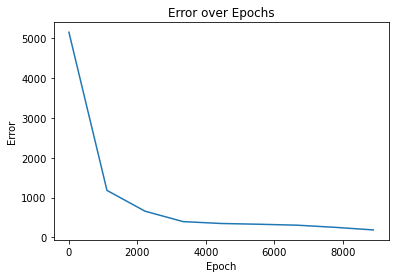

In [175]:
model1.show_error()

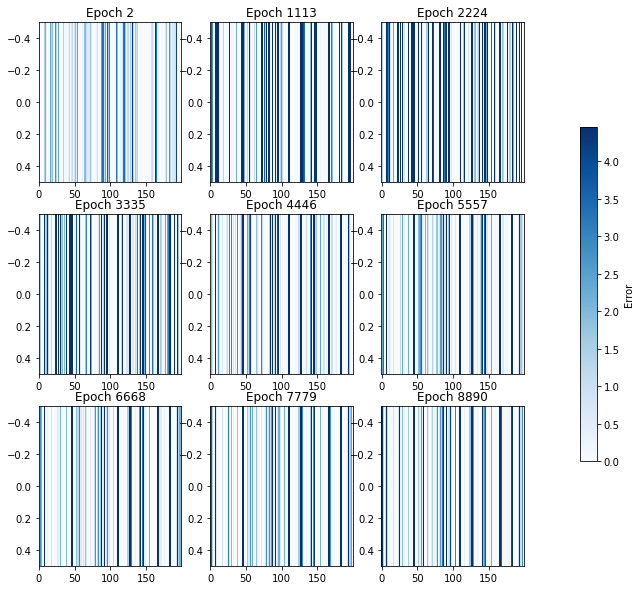

In [176]:
model1.show_matrix_error()

# classification

In [754]:
x_train = easy_train[['x','y']].to_numpy()

y_train = easy_train['c'].to_numpy()
y_train = y_train.astype(int)
y_train = np.eye(2)[y_train]

x_test = easy_train[['x','y']].to_numpy()

y_test = easy_train['c'].to_numpy()
y_test = y_test.astype(int)
y_test = np.eye(2)[y_test]

In [761]:
input_size = x_train.shape[1]
hidden_size = 10
output_size = y_train.shape[1]
epochs = 10
learning_rate = 0.1

model = NeuralNetwork(input_size, hidden_size, output_size,weight_init="normal", activation="sigm", exit="softmax", measure="f1")
model.train(x_train, y_train, epochs, learning_rate)

Epoch 9, F1/MSE Score: 0.3453877639491078



/var/folders/gg/2dzkwxx92bn382_mjh2vf1nh0000gn/T/ipykernel_8602/81240699.py:48: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


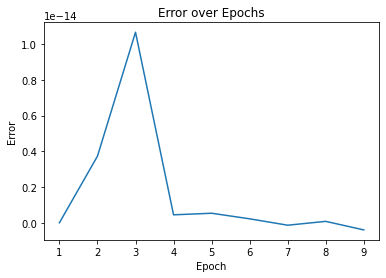

In [729]:
model.show_error()

9


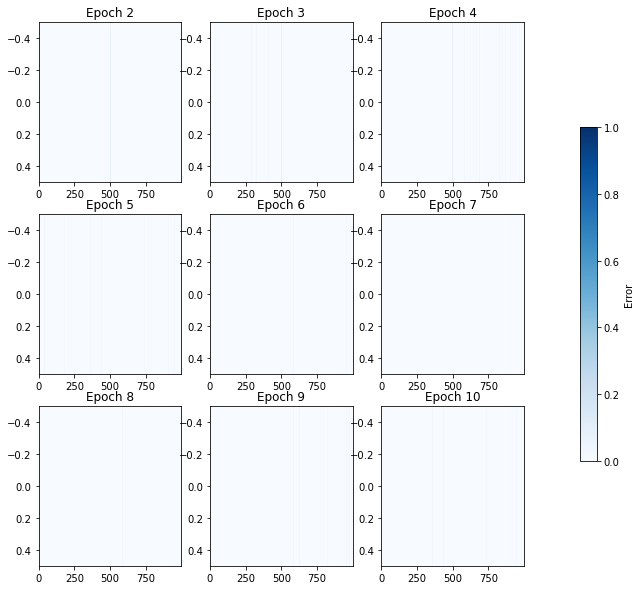

In [730]:
model.show_matrix_error()

# 2 layers

In [ ]:

class NeuralNetwork_2layers:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, activation="relu"):
        np.random.seed(50)
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.errors_array = []
        self.error_matrix=[]
        self.epoch_n=[]
        if activation=="relu": 
            self.activation = self.relu
        elif activation=="tanh": 
            self.activation = self.tanh
        elif activation=="linear": 
            self.activation = self.linear
        elif activation=="sigm": 
            self.activation = self.sigmoid

        # Inicjalizacja wag i biasów dla warstw
        self.weights_input_hidden1 = np.random.randn(input_size, hidden_size1)
        self.bias_hidden1 = np.random.randn(hidden_size1)
        
        self.weights_hidden1_hidden2 = np.random.randn(hidden_size1, hidden_size2)
        self.bias_hidden2 = np.random.randn(hidden_size2)
        
        self.weights_hidden2_output = np.random.randn(hidden_size2, output_size)
        self.bias_output = np.random.randn(output_size)
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    def relu(self, x):
        return np.maximum(0, x)
    def tanh(self, x):
        return np.tanh(x)
    def linear(self, x):
        return x
    def f1_fun(self, output, y_train):
        true_positives = np.sum((output == 1) & (y_train == 1))
        false_positives = np.sum((output == 1) & (y_train == 0))
        false_negatives = np.sum((output == 0) & (y_train == 1))
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        return f1
    
    def softmax(self, x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)
    
    def forward(self, x):
        # Propagacja w przód
        hidden1_input = np.dot(x, self.weights_input_hidden1) + self.bias_hidden1
        hidden1_output = self.sigmoid(hidden1_input)
        
        hidden2_input = np.dot(hidden1_output, self.weights_hidden1_hidden2) + self.bias_hidden2
        hidden2_output = self.sigmoid(hidden2_input)
        
        output_layer_input = np.dot(hidden2_output, self.weights_hidden2_output) + self.bias_output
        output = self.softmax(output_layer_input)
        
        return output, hidden1_output, hidden2_output
    
    def backward(self, x, y, output, hidden1_output, hidden2_output, learning_rate):
        # Obliczanie gradientów
        output_delta = output - y
        
        hidden2_error = np.dot(output_delta, self.weights_hidden2_output.T)
        hidden2_delta = hidden2_error * hidden2_output * (1 - hidden2_output)
        
        hidden1_error = np.dot(hidden2_delta, self.weights_hidden1_hidden2.T)
        hidden1_delta = hidden1_error * hidden1_output * (1 - hidden1_output)
        
        # Aktualizacja wag i biasów
        d_weights_hidden2_output = np.dot(hidden2_output.T, output_delta)
        d_bias_output = np.sum(output_delta, axis=0)
        
        d_weights_hidden1_hidden2 = np.dot(hidden1_output.T, hidden2_delta)
        d_bias_hidden2 = np.sum(hidden2_delta, axis=0)
        
        d_weights_input_hidden1 = np.dot(x.T, hidden1_delta)
        d_bias_hidden1 = np.sum(hidden1_delta, axis=0)
        
        # Update weights and biases
        self.weights_hidden2_output -= learning_rate * d_weights_hidden2_output
        self.bias_output -= learning_rate * d_bias_output
        
        self.weights_hidden1_hidden2 -= learning_rate * d_weights_hidden1_hidden2
        self.bias_hidden2 -= learning_rate * d_bias_hidden2
        
        self.weights_input_hidden1 -= learning_rate * d_weights_input_hidden1
        self.bias_hidden1 -= learning_rate * d_bias_hidden1

        self.errors_array.append(np.sum(output_delta))
        self.error_matrix.append(output_delta)
    
    def train(self, x_train, y_train, epochs, learning_rate):
        for epoch in range(epochs):
            self.epoch_n.append(epoch)
            # Forward pass
            output, hidden1_output, hidden2_output = self.forward(x_train)
            # Backward pass
            self.backward(x_train, y_train, output, hidden1_output, hidden2_output, learning_rate)
        f1 = self.f1_fun(output, y_train)
        print(f'Epoch {epoch}, F1 Score: {f1}\n')
            
    def predict(self, x):
        output, _, _ = self.forward(x)
        return np.argmax(output, axis=1)
    
    def show_error(self):
        plt.plot(range(1, len(self.errors_array)+1), self.errors_array)
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.title('Error over Epochs')
        plt.show()

    def show_matrix_error(self):
        fig, axs = plt.subplots(3,3, figsize=(10, 10))
        k=0
        for i in range(3):
            for j in range(3):
                ax = axs[i, j]
                error_values = self.error_matrix[k] 
                k+=1
                im = ax.imshow(error_values.reshape(1, -1), cmap='Blues', aspect='auto', vmin=0, vmax=self.error_matrix[0].max())
                ax.set_title(f'Epoch {self.epoch_n[k]+1}')
        cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.03, pad=0.1)
        cbar.set_label('Error')
        plt.show()

In [549]:
x_train = ring_train[['x','y']].to_numpy()

y_train = ring_train['c'].to_numpy()
y_train = y_train.astype(int)
y_train = np.eye(3)[y_train]

x_test = ring_test[['x','y']].to_numpy()

y_test = ring_test['c'].to_numpy()
y_test = y_test.astype(int)
y_test = np.eye(3)[y_test]

Epoch 999, F1 Score: 0



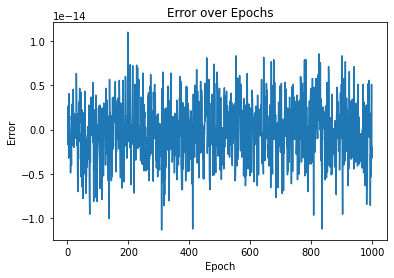

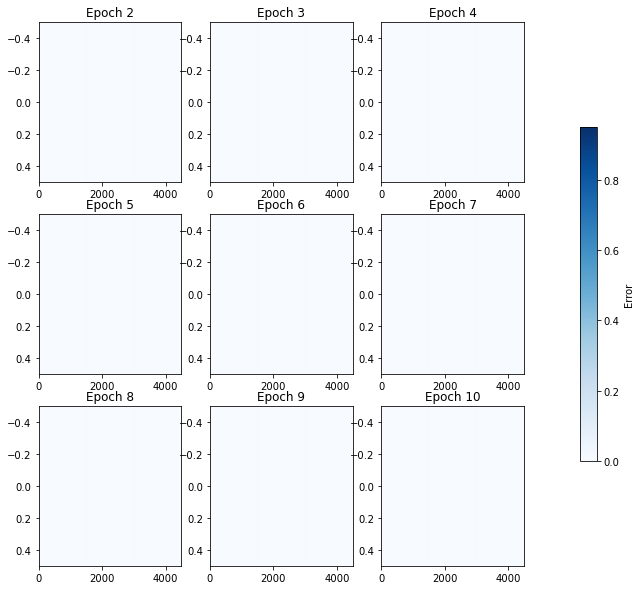

In [200]:
input_size = x_train.shape[1]
output_size = y_train.shape[1]
hidden_size1=50
hidden_size2=10
epochs = 1000
learning_rate = 0.001

model = NeuralNetwork_2layers(input_size, hidden_size1, hidden_size2, output_size, activation="sigm")
model.train(x_train, y_train, epochs, learning_rate)
model.show_error()
model.show_matrix_error()

# easy

In [201]:
x_train = ring5_train[['x','y']].to_numpy()

y_train = ring5_train['c'].to_numpy()
y_train = y_train.astype(int)
y_train = np.eye(5)[y_train]

x_test = easy_train[['x','y']].to_numpy()

y_test = easy_train['c'].to_numpy()
y_test = y_test.astype(int)
y_test = np.eye(5)[y_test]

Epoch 99, F1 Score: 0



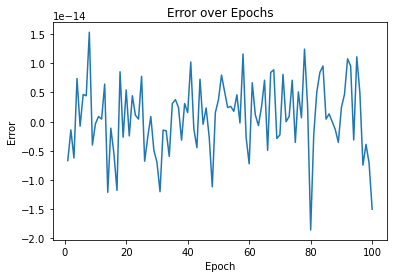

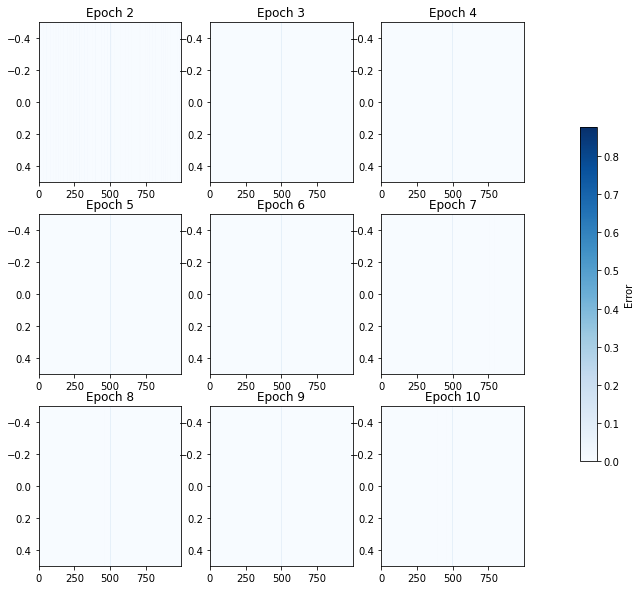

In [207]:
input_size = x_train.shape[1]
output_size = y_train.shape[1]
hidden_size1=10
hidden_size2=10
epochs = 100
learning_rate = 0.01

model = NeuralNetwork_2layers(input_size, hidden_size1, hidden_size2, output_size, activation="relu")
model.train(x_train, y_train, epochs, learning_rate)
model.show_error()
model.show_matrix_error()

In [206]:
model.f1_fun(np.eye(2)[model.predict(x_test)],y_test)

0.708

# xor

In [204]:
x_train = xor_train[['x','y']].to_numpy()

y_train = xor_train['c'].to_numpy()
y_train = y_train.astype(int)
y_train = np.eye(2)[y_train]

x_test = xor_train[['x','y']].to_numpy()

y_test = xor_train['c'].to_numpy()
y_test = y_test.astype(int)
y_test = np.eye(2)[y_test]

/var/folders/gg/2dzkwxx92bn382_mjh2vf1nh0000gn/T/ipykernel_8602/3559830671.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


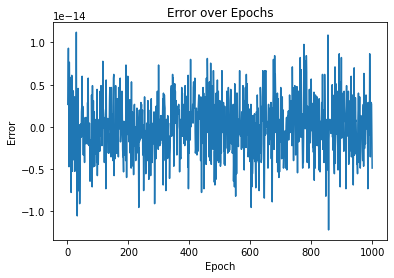

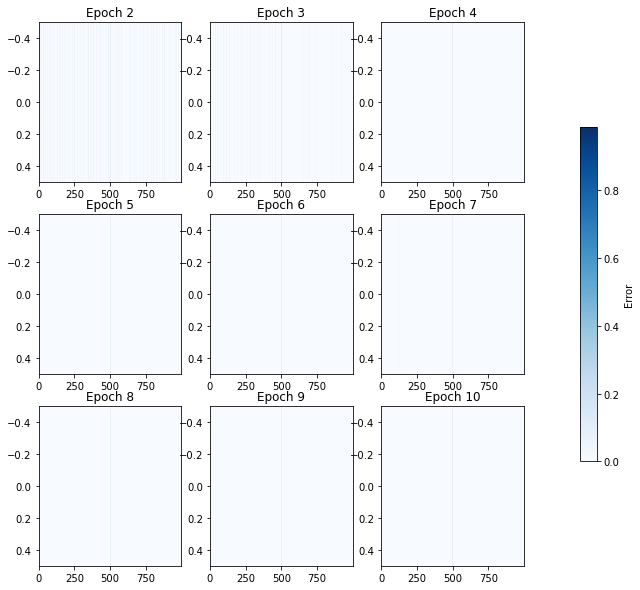

In [144]:
input_size = x_train.shape[1]
output_size = y_train.shape[1]
hidden_size1=30
hidden_size2=30
epochs = 1000
learning_rate = 0.01

model = NeuralNetwork_2layers(input_size, hidden_size1, hidden_size2, output_size)
model.train(x_train, y_train, epochs, learning_rate)
model.show_error()
model.show_matrix_error()

# Final Tests

# Multi Layer Perceptron - elastic number of layers

In [15]:
def show_comparison(epochs, errors_array, s1, s2, s3,max_range=1000, title=""):
    step = int(epochs/8)
    x=[i for i in range(0, epochs+1, step)]
    plt.plot(x, errors_array[0], label=s1)
    plt.plot(x, errors_array[1], label=s2)
    plt.plot(x, errors_array[2], label=s3)
    plt.xlabel('Epochs')
    plt.ylabel('Błąd MSE')
    plt.xlim(0,max_range)
    plt.title(title)
    plt.legend() 

# Set 1

In [7]:
# preprocessing
x_train = np.array(simple_train['x'])
y_train= np.array(simple_train['y'])
x_test = np.array(simple_test['x'])
y_test = np.array(simple_test['y'])

x_train = np.array([[x] for x in x_train])
y_train = np.array([[x] for x in y_train])
x_test = np.array([[x] for x in x_test])
y_test = np.array([[x] for x in y_test])

In [8]:
model = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="sigm", normalization="none", weight_init="normal")
model.train(x_train, y_train, epochs=10000)
model.print_mse_test(x_test,y_test)

Epoch 10000, Training MSE Score: 6.082150414822305

MSE test = 30.333290077837756


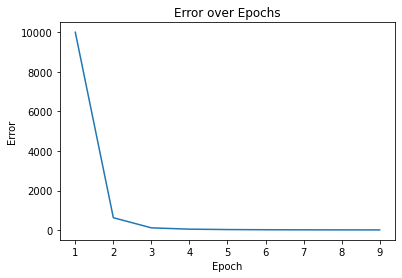

In [9]:
model.show_error()

# normalization vs none

In [1297]:
# preprocessing
errors_array = []

print("none:")
model1 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="sigm", normalization="none", weight_init="he")
model1.train(x_train, y_train, epochs=10000)
model1.print_mse_test(x_test,y_test)
errors_array.append(model1.return_erros())

print("\nminmax:")
model2 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="sigm", normalization="minmax", weight_init="he")
model2.train(x_train, y_train, epochs=10000)
model2.print_mse_test(x_test,y_test)
errors_array.append(model2.return_erros())

print("\nstd:")
model3 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="sigm", normalization="std", weight_init="he")
model3.train(x_train, y_train, epochs=10000)
model3.print_mse_test(x_test,y_test)
errors_array.append(model3.return_erros())

none:
Epoch 10000, Training MSE Score: 23.649278110916644

MSE test = 41.11266058781471

minmax:
Epoch 10000, Training MSE Score: 5.451995201072829

MSE test = 26.92262767517395

std:
Epoch 10000, Training MSE Score: 1.9148762408686553

MSE test = 23.795527643734513


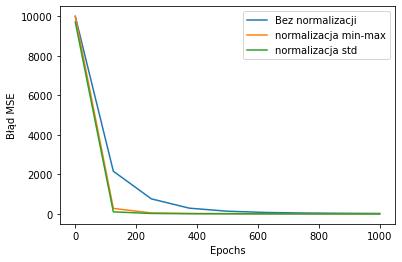

In [1313]:
show_comparison(epochs, errors_array, "Bez normalizacji", "normalizacja min-max", "normalizacja std", "")

# Moment

In [20]:
errors_array = []

model1 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="sigm", normalization="std", weight_init="he")
model1.train(x_train, y_train, epochs=1000)
model1.print_mse_test(x_test,y_test)
errors_array.append(model1.return_erros())

model2 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="sigm", normalization="std", weight_init="he",
                    rmsProp=False, momentum=True)
model2.train(x_train, y_train, epochs=1000)
model2.print_mse_test(x_test,y_test)
errors_array.append(model2.return_erros())

model3 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[40], output_size=y_train.shape[1], activation="sigm", normalization="minmax", weight_init="he",
                    rmsProp=False, momentum=True)
model3.train(x_train, y_train, epochs=1000)
model3.print_mse_test(x_test,y_test)
errors_array.append(model3.return_erros())

Epoch 1000, Training MSE Score: 163.90031503502087

MSE test = 126.01566999680746
Epoch 1000, Training MSE Score: 13.081069654608914

MSE test = 33.53936953514888
Epoch 1000, Training MSE Score: 2.0771467544439175

MSE test = 24.001183323087407


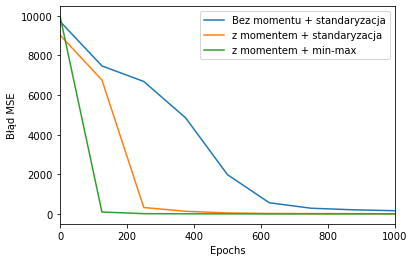

In [24]:
epochs=1000
show_comparison(epochs, errors_array, "Bez momentu + standaryzacja", "z momentem + standaryzacja", "z momentem + min-max",max_range=1000, title="")

# Moment, RMSProp, Adam

In [25]:
errors_array = []

model1 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="sigm", normalization="std", weight_init="he",
    rmsProp=False, momentum=True)
model1.train(x_train, y_train, epochs=1000)
model1.print_mse_test(x_test,y_test)
errors_array.append(model1.return_erros())

model2 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="relu", normalization="std", weight_init="he",
                    rmsProp=True, momentum=False)
model2.train(x_train, y_train, epochs=1000)
model2.print_mse_test(x_test,y_test)
errors_array.append(model2.return_erros())

model3 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[40], output_size=y_train.shape[1], activation="relu", normalization="std", weight_init="he",
                    rmsProp=True, momentum=True)
model3.train(x_train, y_train, epochs=1000)
model3.print_mse_test(x_test,y_test)
errors_array.append(model3.return_erros())

Epoch 1000, Training MSE Score: 13.081069654608914

MSE test = 33.53936953514888
Epoch 1000, Training MSE Score: 1.9530278970028212

MSE test = 24.460747831786943
Epoch 1000, Training MSE Score: 20.125000681318657

MSE test = 38.56254312141204


In [1398]:
def show_comparison(epochs, errors_array, s1, s2, s3, title=""):
    step = int(epochs/8)
    x=[i for i in range(0, epochs+1, step)]
    plt.plot(x, errors_array[0], label=s1)
    plt.plot(x, errors_array[1], label=s2)
    plt.plot(x, errors_array[2], label=s3)
    plt.xlim(0,200)
    plt.xlabel('Epochs')
    plt.ylabel('Błąd MSE')
    plt.title(title)
    plt.legend() 

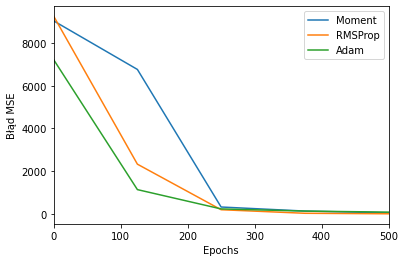

In [27]:
show_comparison(epochs, errors_array, "Moment", "RMSProp", "Adam", max_range=500 ,title="")

# Batches

In [33]:
def show_comparison(epochs,max_show, errors_array, s1, s2, s3, title=""):
    step = int(epochs/8)
    x=[i for i in range(0, epochs+1, step)]
    plt.plot(x, errors_array[0], label=s1)
    plt.plot(x, errors_array[1], label=s2)
    plt.plot(x, errors_array[2], label=s3)
    plt.xlim(0,max_show)
    plt.xlabel('Epochs')
    plt.ylabel('Błąd MSE')
    plt.title(title)
    plt.legend() 

In [28]:
errors_array = []

model1 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="relu", normalization="std", weight_init="he",
                     rmsProp=True, momentum=True)
model1.train(x_train, y_train, epochs=1000)
model1.print_mse_test(x_test,y_test)
errors_array.append(model1.return_erros())

model2 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="relu", normalization="std", weight_init="he",
                    rmsProp=True, momentum=True)
model2.train(x_train, y_train, epochs=1000, batch_size=10, batching=True)
model2.print_mse_test(x_test,y_test)
errors_array.append(model2.return_erros())

model3 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="relu", normalization="minmax", weight_init="he",
                    rmsProp=True, momentum=True)
model3.train(x_train, y_train, epochs=1000, batch_size=5, batching=True)
model3.print_mse_test(x_test,y_test)
errors_array.append(model3.return_erros())

Epoch 1000, Training MSE Score: 27.07925477972184

MSE test = 44.822444939425914
Epoch 1000, Training MSE Score: 0.3707445355054548

MSE test = 22.007365980836916
Epoch 1000, Training MSE Score: 1612.843510428149

MSE test = 1488.4356667131465


In [29]:
model3 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="relu", normalization="minmax", weight_init="he",
                    rmsProp=True, momentum=True)
model3.train(x_train, y_train, epochs=1000, batch_size=20, batching=True)
model3.print_mse_test(x_test,y_test)
errors_array.append(model3.return_erros())

Epoch 1000, Training MSE Score: 133.36182937471676

MSE test = 125.2798695113107


In [30]:
model2 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="sigm", normalization="std", weight_init="he",
                    rmsProp=True, momentum=True)
model2.train(x_train, y_train, epochs=1000, batch_size=10, batching=True)
model2.print_mse_test(x_test,y_test)

Epoch 1000, Training MSE Score: 6319.520997288166

MSE test = 4330.8934787974185


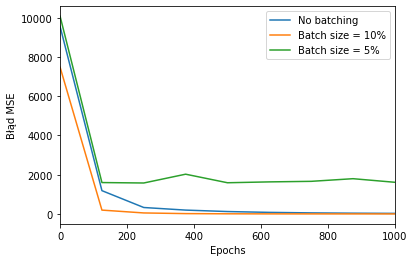

In [34]:
max_show=1000
show_comparison(epochs,max_show, errors_array, s1="No batching", s2="Batch size = 10%", s3="Batch size = 5%", title="")

# Weight init

In [1432]:
errors_array = []

model1 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="sigm", normalization="std", weight_init="he",
                     rmsProp=True, momentum=True)
model1.train(x_train, y_train, epochs=10000, batch_size=10, batching=True)
model1.print_mse_test(x_test,y_test)
errors_array.append(model1.return_erros())

model2 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="relu", normalization="std", weight_init="he",
                    rmsProp=True, momentum=True)
model2.train(x_train, y_train, epochs=10000, batch_size=8, batching=True)
model2.print_mse_test(x_test,y_test)
errors_array.append(model2.return_erros())

model3 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="tanh", normalization="std", weight_init="he",
                    rmsProp=True, momentum=True)
model3.train(x_train, y_train, epochs=10000, batch_size=10, batching=True)
model3.print_mse_test(x_test,y_test)
errors_array.append(model3.return_erros())

Epoch 10000, Training MSE Score: 0.19850896645472804

MSE test = 21.617061066640854
Epoch 10000, Training MSE Score: 0.12142327832099511

MSE test = 21.151884035420345
Epoch 10000, Training MSE Score: 0.3199109311630187

MSE test = 21.752537730746166


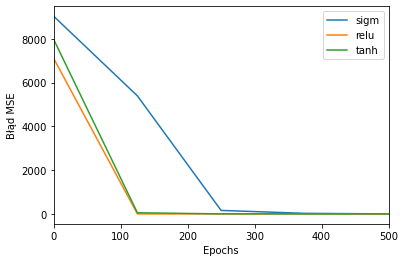

In [1435]:
max_show=500
show_comparison(epochs,max_show, errors_array, s1="sigm", s2="relu", s3="tanh", title="")

# Grand testing

In [35]:
ring5_train = pd.read_csv('classification/rings5-regular-training.csv')
ring5_test = pd.read_csv('classification/rings5-regular-test.csv')
easy_train = pd.read_csv('classification/easy-training.csv')
easy_test = pd.read_csv('classification/easy-test.csv')
ring_train = pd.read_csv('classification/rings3-regular-training.csv')
ring_test = pd.read_csv('classification/rings3-regular-test.csv')
xorB_train = pd.read_csv('classification/xor3-balance-training.csv')
xorB_test = pd.read_csv('classification/xor3-balance-test.csv')
xor_train = pd.read_csv('classification/xor3-training.csv')
xor_test = pd.read_csv('classification/xor3-test.csv')

Text(0.5, 1.0, 'Set 1 [C]')

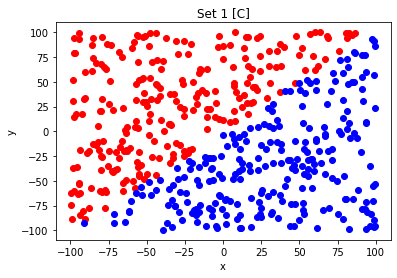

In [1458]:
class_false = easy_train[easy_train['c'] == False]
class_true = easy_train[easy_train['c'] == True]

plt.scatter(class_false['x'], class_false['y'], color='red', label='False')
plt.scatter(class_true['x'], class_true['y'], color='blue', label='True')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Set 1 [C]")

Text(0.5, 1.0, 'Set 2 [C]')

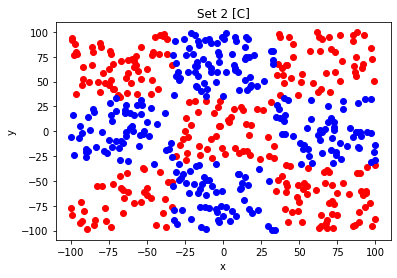

In [1459]:
class_false = xor_train[xor_train['c'] == False]
class_true = xor_train[xor_train['c'] == True]

plt.scatter(class_false['x'], class_false['y'], color='red', label='False')
plt.scatter(class_true['x'], class_true['y'], color='blue', label='True')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Set 2 [C]")

Text(0.5, 1.0, 'Set 3 [C]')

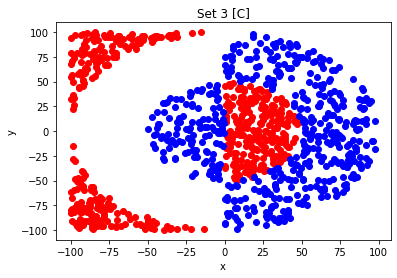

In [1460]:
class_false = ring_train[ring_train['c'] == False]
class_true = ring_train[ring_train['c'] == True]

plt.scatter(class_false['x'], class_false['y'], color='red', label='False')
plt.scatter(class_true['x'], class_true['y'], color='blue', label='True')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Set 3 [C]")

Text(0.5, 1.0, 'Set 4 [C]')

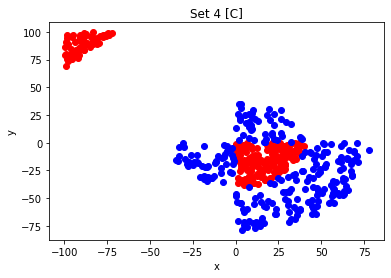

In [1462]:
class_false = ring5_train[ring5_train['c'] == False]
class_true = ring5_train[ring5_train['c'] == True]

plt.scatter(class_false['x'], class_false['y'], color='red', label='False')
plt.scatter(class_true['x'], class_true['y'], color='blue', label='True')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Set 4 [C]")

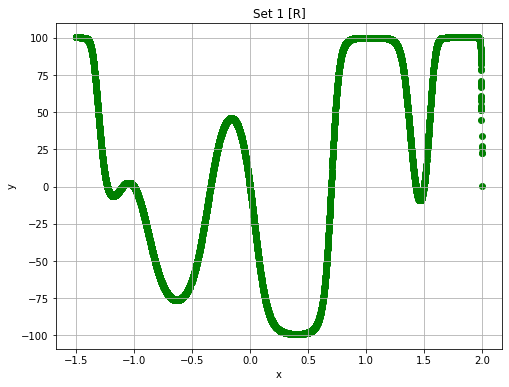

In [1463]:
plt.figure(figsize=(8, 6))
plt.scatter(multimodal_train['x'], multimodal_train['y'], marker='o', color='green')
plt.title('Set 1 [R]')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

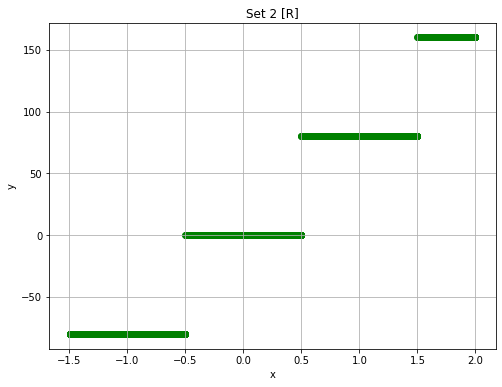

In [1468]:
plt.figure(figsize=(8, 6))
plt.scatter(stepsLarge_train['x'], stepsLarge_train['y'], marker='o', color='green')
plt.title('Set 2 [R]')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

# easy

In [47]:
def show_comparison(epochs,max_show, errors_array, s1, s2, s3, title=""):
    step = int(epochs/8)
    x=[i for i in range(0, epochs+1, step)]
    plt.plot(x, errors_array[0], label=s1)
    plt.plot(x, errors_array[1], label=s2)
    plt.plot(x, errors_array[2], label=s3)
    plt.xlim(0,max_show)
    plt.xlabel('Epochs')
    plt.ylabel('Błąd Cross Entropy')
    plt.title(title)
    plt.legend() 

In [36]:
x_train = easy_train[['x','y']].to_numpy()

y_train = easy_train['c'].to_numpy()
y_train = y_train.astype(int)
y_train = np.eye(2)[y_train]

x_test = easy_test[['x','y']].to_numpy()

y_test = easy_test['c'].to_numpy()
y_test = y_test.astype(int)
y_test = np.eye(2)[y_test]

In [56]:
errors_array = []

model1 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="tanh", normalization="std", weight_init="he",
                     rmsProp=True, momentum=True, measure="f1",exit="softmax")
model1.train(x_train, y_train, epochs=1000, batch_size=10, batching=True)
model1.print_f1_test(x_test,y_test)
errors_array.append(model1.return_erros())

model2 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="sigm", normalization="std", weight_init="he",
                    rmsProp=True, momentum=True, measure="f1",exit="softmax")
model2.train(x_train, y_train, epochs=1000, batch_size=10, batching=True)
model2.print_f1_test(x_test,y_test)
errors_array.append(model2.return_erros())

model3 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="relu", normalization="std", weight_init="he",
                    rmsProp=True, momentum=True, measure="f1",exit="softmax")
model3.train(x_train, y_train, epochs=1000, batch_size=10, batching=True)
model3.print_f1_test(x_test,y_test)
errors_array.append(model3.return_erros())

Epoch 1000, Training Cross-Entropy Score: 2.669684369284243

Epoch 1000, Training F1 Score: 0.974

F1 score test = 0.912
Epoch 1000, Training Cross-Entropy Score: 3.8532394494673805

Epoch 1000, Training F1 Score: 0.962

F1 score test = 0.914
Epoch 1000, Training Cross-Entropy Score: 5.131444270839204

Epoch 1000, Training F1 Score: 0.91

F1 score test = 0.8599999999999999


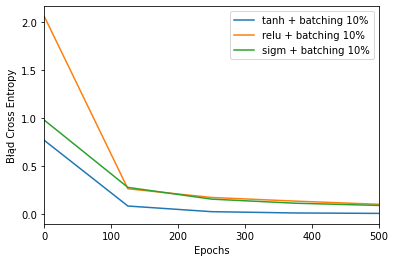

In [53]:
max_show=500
show_comparison(epochs,max_show, errors_array, s1="tanh + batching 10%", s2="relu + batching 10%", s3="sigm + batching 10%", title="")

# xor

In [54]:
x_train = xor_train[['x','y']].to_numpy()

y_train = xor_train['c'].to_numpy()
y_train = y_train.astype(int)
y_train = np.eye(2)[y_train]

x_test = xor_test[['x','y']].to_numpy()

y_test = xor_test['c'].to_numpy()
y_test = y_test.astype(int)
y_test = np.eye(2)[y_test]

In [57]:
errors_array = []

model1 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="tanh", normalization="std", weight_init="he",
                     rmsProp=True, momentum=True, measure="f1",exit="softmax")
model1.train(x_train, y_train, epochs=1000, batch_size=10, batching=True)
model1.print_f1_test(x_test,y_test)
errors_array.append(model1.return_erros())

model2 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50,20], output_size=y_train.shape[1], activation="tanh", normalization="std", weight_init="he",
                    rmsProp=True, momentum=True, measure="f1",exit="softmax")
model2.train(x_train, y_train, epochs=1000, batch_size=10, batching=True)
model2.print_f1_test(x_test,y_test)
errors_array.append(model2.return_erros())

model3 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50,20,50], output_size=y_train.shape[1], activation="tanh", normalization="std", weight_init="he",
                    rmsProp=True, momentum=True, measure="f1",exit="softmax")
model3.train(x_train, y_train, epochs=1000, batch_size=10, batching=True)
model3.print_f1_test(x_test,y_test)
errors_array.append(model3.return_erros())

Epoch 1000, Training Cross-Entropy Score: 2.669684369284243

Epoch 1000, Training F1 Score: 0.974

F1 score test = 0.912
Epoch 1000, Training Cross-Entropy Score: 1.1196452406028838

Epoch 1000, Training F1 Score: 0.99

F1 score test = 0.916
Epoch 1000, Training Cross-Entropy Score: 0.7471563997086487

Epoch 1000, Training F1 Score: 0.988

F1 score test = 0.932


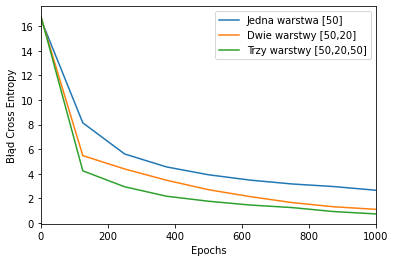

In [59]:
max_show=1000
show_comparison(epochs,max_show, errors_array, s1="Jedna warstwa [50]", s2="Dwie warstwy [50,20]", s3="Trzy warstwy [50,20,50]", title="")

# ring3

In [71]:
x_train = ring_train[['x','y']].to_numpy()

y_train = ring_train['c'].to_numpy()
y_train = y_train.astype(int)
y_train = np.eye(3)[y_train]

x_test = ring_test[['x','y']].to_numpy()

y_test = ring_test['c'].to_numpy()
y_test = y_test.astype(int)
y_test = np.eye(3)[y_test]

In [76]:
errors_array = []

model1 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="tanh", normalization="std", weight_init="he",
                     rmsProp=True, momentum=True, measure="f1",exit="softmax")
model1.train(x_train, y_train, epochs=1000, batch_size=10, batching=True)
model1.print_f1_test(x_test,y_test)
errors_array.append(model1.return_erros())

model2 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50,20], output_size=y_train.shape[1], activation="tanh", normalization="std", weight_init="he",
                    rmsProp=True, momentum=True, measure="f1",exit="softmax")
model2.train(x_train, y_train, epochs=1000, batch_size=10, batching=True)
model2.print_f1_test(x_test,y_test)
errors_array.append(model2.return_erros())

model3 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50,20,50], output_size=y_train.shape[1], activation="tanh", normalization="std", weight_init="he",
                    rmsProp=True, momentum=True, measure="f1",exit="softmax")
model3.train(x_train, y_train, epochs=1000, batch_size=10, batching=True)
model3.print_f1_test(x_test,y_test)
errors_array.append(model3.return_erros())

Epoch 1000, Training Cross-Entropy Score: 3.639974853119286

Epoch 1000, Training F1 Score: 0.9686666666666667

F1 score test = 0.9405
Epoch 1000, Training Cross-Entropy Score: 1.5149130897334737

Epoch 1000, Training F1 Score: 0.9586666666666667

F1 score test = 0.925
Epoch 1000, Training Cross-Entropy Score: 1.7710870601152597

Epoch 1000, Training F1 Score: 0.986

F1 score test = 0.94


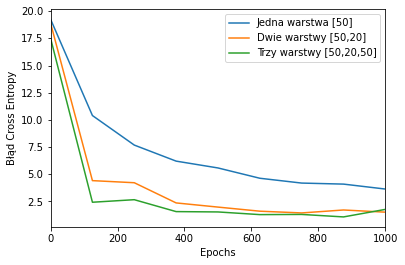

In [77]:
max_show=1000
show_comparison(epochs,max_show, errors_array, s1="Jedna warstwa [50]", s2="Dwie warstwy [50,20]", s3="Trzy warstwy [50,20,50]", title="")

In [80]:
x_train = ring5_train[['x','y']].to_numpy()

y_train = ring5_train['c'].to_numpy()
y_train = y_train.astype(int)
y_train = np.eye(5)[y_train]

x_test = ring5_test[['x','y']].to_numpy()

y_test = ring5_test['c'].to_numpy()
y_test = y_test.astype(int)
y_test = np.eye(5)[y_test]

In [81]:
errors_array = []

model1 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50], output_size=y_train.shape[1], activation="tanh", normalization="std", weight_init="he",
                     rmsProp=True, momentum=True, measure="f1",exit="softmax")
model1.train(x_train, y_train, epochs=1000, batch_size=10, batching=True)
model1.print_f1_test(x_test,y_test)
errors_array.append(model1.return_erros())

model2 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50,20], output_size=y_train.shape[1], activation="tanh", normalization="std", weight_init="he",
                    rmsProp=True, momentum=True, measure="f1",exit="softmax")
model2.train(x_train, y_train, epochs=1000, batch_size=10, batching=True)
model2.print_f1_test(x_test,y_test)
errors_array.append(model2.return_erros())

model3 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50,20,50], output_size=y_train.shape[1], activation="tanh", normalization="std", weight_init="he",
                    rmsProp=True, momentum=True, measure="f1",exit="softmax")
model3.train(x_train, y_train, epochs=1000, batch_size=10, batching=True)
model3.print_f1_test(x_test,y_test)
errors_array.append(model3.return_erros())

Epoch 1000, Training Cross-Entropy Score: 3.8507601558139752

Epoch 1000, Training F1 Score: 0.9648

F1 score test = 0.9025
Epoch 1000, Training Cross-Entropy Score: 1.3711568358811261

Epoch 1000, Training F1 Score: 0.9896

F1 score test = 0.9335
Epoch 1000, Training Cross-Entropy Score: 1.5780045263374798

Epoch 1000, Training F1 Score: 0.9344

F1 score test = 0.9


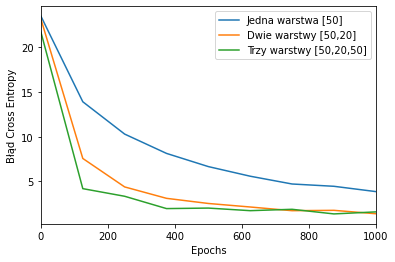

In [82]:
max_show=1000
show_comparison(epochs,max_show, errors_array, s1="Jedna warstwa [50]", s2="Dwie warstwy [50,20]", s3="Trzy warstwy [50,20,50]", title="")

# regresja - multimodal

In [91]:
def show_comparison(epochs,max_show, errors_array, s1, s2, s3, title=""):
    step = int(epochs/8)
    x=[i for i in range(0, epochs+1, step)]
    plt.plot(x, errors_array[0], label=s1)
    plt.plot(x, errors_array[1], label=s2)
    plt.plot(x, errors_array[2], label=s3)
    plt.xlim(0,max_show)
    plt.xlabel('Epochs')
    plt.ylabel('Błąd MSE')
    plt.title(title)
    plt.legend() 

In [86]:
# preprocessing
x_train = np.array(multimodal_train['x'])
y_train= np.array(multimodal_train['y'])
x_test = np.array(multimodal_test['x'])
y_test = np.array(multimodal_test['y'])

x_train = np.array([[x] for x in x_train])
y_train = np.array([[x] for x in y_train])
x_test = np.array([[x] for x in x_test])
y_test = np.array([[x] for x in y_test])

In [88]:
errors_array = []

model1 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50,20], output_size=y_train.shape[1], activation="relu", normalization="std", weight_init="he",
                     rmsProp=True, momentum=True, measure="mse",exit="linear")
model1.train(x_train, y_train, epochs=1000, batch_size=10, batching=True)
model1.print_mse_test(x_test,y_test)
errors_array.append(model1.return_erros())

model2 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50,50], output_size=y_train.shape[1], activation="relu", normalization="std", weight_init="he",
                    rmsProp=True, momentum=True, measure="mse",exit="linear")
model2.train(x_train, y_train, epochs=1000, batch_size=10, batching=True)
model2.print_mse_test(x_test,y_test)
errors_array.append(model2.return_erros())

model3 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50,20,50], output_size=y_train.shape[1], activation="relu", normalization="std", weight_init="he",
                    rmsProp=True, momentum=True, measure="mse",exit="linear")
model3.train(x_train, y_train, epochs=1000, batch_size=10, batching=True)
model3.print_mse_test(x_test,y_test)
errors_array.append(model3.return_erros())

Epoch 1000, Training MSE Score: 9.501821634014735

MSE test = 4.610023358035065
Epoch 1000, Training MSE Score: 4.202014902755606

MSE test = 9.29256379435653
Epoch 1000, Training MSE Score: 4.473893129097716

MSE test = 17.531271575318243


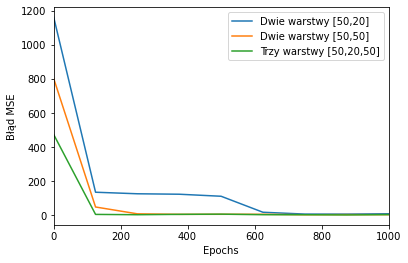

In [92]:
max_show=1000
show_comparison(epochs,max_show, errors_array, s1="Dwie warstwy [50,20]", s2="Dwie warstwy [50,50]", s3="Trzy warstwy [50,20,50]", title="")

# steps large

In [95]:
# preprocessing
x_train = np.array(stepsLarge_train['x'])
y_train= np.array(stepsLarge_train['y'])
x_test = np.array(stepsLarge_test['x'])
y_test = np.array(stepsLarge_test['y'])

x_train = np.array([[x] for x in x_train])
y_train = np.array([[x] for x in y_train])
x_test = np.array([[x] for x in x_test])
y_test = np.array([[x] for x in y_test])

In [96]:
errors_array = []

model1 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50,20], output_size=y_train.shape[1], activation="relu", normalization="std", weight_init="he",
                     rmsProp=True, momentum=True, measure="mse",exit="linear")
model1.train(x_train, y_train, epochs=10000, batch_size=10, batching=True)
model1.print_mse_test(x_test,y_test)
errors_array.append(model1.return_erros())

model2 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50,50], output_size=y_train.shape[1], activation="relu", normalization="std", weight_init="he",
                    rmsProp=True, momentum=True, measure="mse",exit="linear")
model2.train(x_train, y_train, epochs=10000, batch_size=10, batching=True)
model2.print_mse_test(x_test,y_test)
errors_array.append(model2.return_erros())

model3 = MultiLayers(input_size=x_train.shape[1], layer_sizes=[50,20,50], output_size=y_train.shape[1], activation="relu", normalization="std", weight_init="he",
                    rmsProp=True, momentum=True, measure="mse",exit="linear")
model3.train(x_train, y_train, epochs=10000, batch_size=10, batching=True)
model3.print_mse_test(x_test,y_test)
errors_array.append(model3.return_erros())

Epoch 10000, Training MSE Score: 7.4807402938375755

MSE test = 5.971717778765462
Epoch 10000, Training MSE Score: 7.900886775214676

MSE test = 9.117363109237347
Epoch 10000, Training MSE Score: 6.445322537908379

MSE test = 9.402825942056541


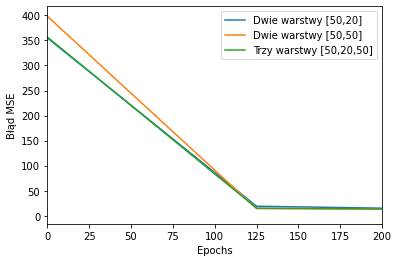

In [99]:
max_show=200
show_comparison(epochs,max_show, errors_array, s1="Dwie warstwy [50,20]", s2="Dwie warstwy [50,50]", s3="Trzy warstwy [50,20,50]", title="")